# 09_CraneCam_ZHAW_Comparison
In diesem Jupyter Notebook werden Statistiken und Visualisierungen aus Daten RMSE-Werten der Metashape-Reports generiert.

Die Daten basieren auf Bildern folgender Aufnahmedaten der CraneCam an der ZHAW:

- 24.02.2025 
- 20.03.2025

### Import der Libraries

In [1]:
import pandas as pd
import glob
import os
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import laspy
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import re
import traceback

### Definition der Grundlagedaten

In [2]:
# CSV-Verzeichnis
csv_dir = "D:\\BTh11_Asuwertung_PC\\fhnw_code\\BTh11_Trieblaengenwachstum\\09_CraneCam_ZHAW_Comparison\\90_BaseData\\CSV"
print("Daten in CSV-Verzeichnis:", os.listdir(csv_dir))

# # PointCloud-Verzeichnis auf HDD
# pc_hdd_dir = "F:\\530_PointClouds_UAV"
# print("Daten in PointCloud-Verzeichnis (HDD):", os.listdir(pc_hdd_dir))

# PointCloud-Verzeichnis 
pc_dir = "D:\\BTh11_Asuwertung_PC\\fhnw_code\\BTh11_Trieblaengenwachstum\\09_CraneCam_ZHAW_Comparison\\90_BaseData\\PointCloud"
print("Daten in PointCloud-Verzeichnis:", os.listdir(pc_dir))


Daten in CSV-Verzeichnis: ['Vergleich_CraneCam_ZHAW.csv']
Daten in PointCloud-Verzeichnis: ['20250224_CraneCam_ZHAW_clipped.las', '20250224_CraneCam_ZHAW_clipped_new.las', '20250320_CraneCam_ZHAW_clipped.las', '20250320_CraneCam_ZHAW_clipped_new.las']


## 2. Analyse Punktwolken (clipped) 
Die Punkwolken werden aufgrund der Attribute analysiert, um eine Erkenntnis aus den verschiedenen Aufnahmedaten zu erhalten.

### 2.1 Histogramm der Confidence-Werte der Punktwolken in Kategorien
In dieser Visualisierung werden alle Punkte der Punktwolken im Grundlagenverzeichnis "09_CraneCam_ZHAW_Copmparison\90_BaseData\PointCloud" eingelesen und in Bezug auf das Attribut "confidence" in Kategorien eingeteilt. Pro Kategorie (1 - >12) werden die normierten Anteile pro Aufnahmedatum dargestellt.

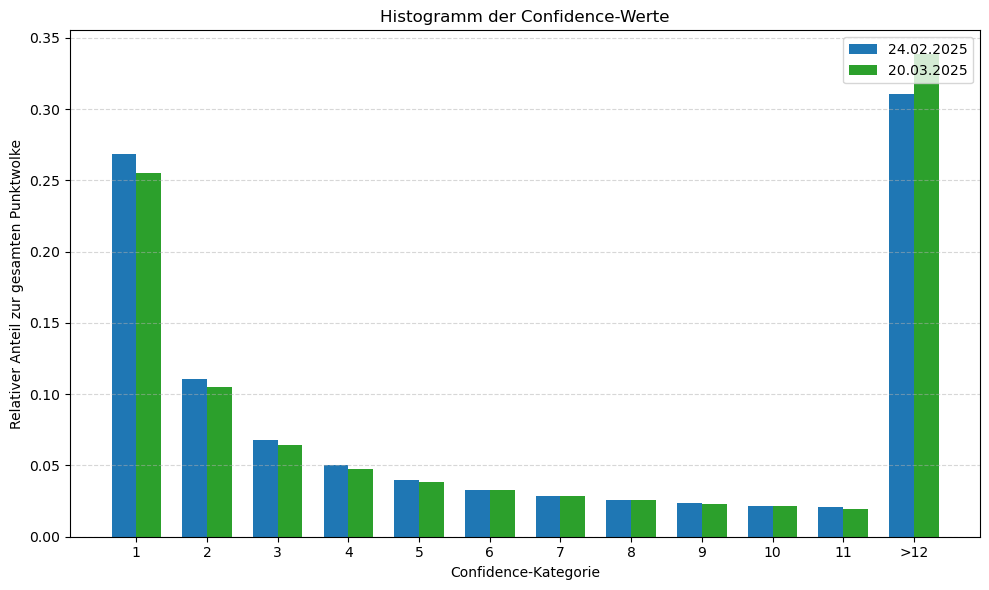

In [3]:
# Pfade zu den beiden Punktwolken (LAS-Dateien)
CraneCamZHAW20250224 = "D:\\BTh11_Asuwertung_PC\\fhnw_code\\BTh11_Trieblaengenwachstum\\09_CraneCam_ZHAW_Comparison\\90_BaseData\\PointCloud\\20250224_CraneCam_ZHAW_clipped.las"
CraneCamZHAW20250320 = "D:\\BTh11_Asuwertung_PC\\fhnw_code\\BTh11_Trieblaengenwachstum\\09_CraneCam_ZHAW_Comparison\\90_BaseData\\PointCloud\\20250320_CraneCam_ZHAW_clipped.las"

# Dateien pr\üfen
if not os.path.exists(CraneCamZHAW20250320):
    raise FileNotFoundError(f"Datei nicht gefunden: {CraneCamZHAW20250320}")
if not os.path.exists(CraneCamZHAW20250224):
    raise FileNotFoundError(f"Datei nicht gefunden: {CraneCamZHAW20250224}")

# Bins definieren: 1–12, letzte Kategorie >12
bins = list(np.arange(1, 13)) + [np.inf]
bin_labels = [str(i) for i in range(1, 12)] + [">12"]

# Funktion zur Berechnung des normalisierten Histogramms der Confidence-Werte
def compute_confidence_histogram(file_path):
    las = laspy.read(file_path)
    # Prüfen, ob das Feld "confidence" vorhanden ist
    if "confidence" not in las.point_format.dimension_names:
        raise ValueError(f"Feld 'confidence' fehlt in Datei: {file_path}")
    confidence = las['confidence']
    counts, _ = np.histogram(confidence, bins=bins)
    total = np.sum(counts)
    norm_counts = counts / total if total > 0 else np.zeros_like(counts)
    return norm_counts

# Histogramme für beide Punktwolken berechnen
hist1 = compute_confidence_histogram(CraneCamZHAW20250224)
hist2 = compute_confidence_histogram(CraneCamZHAW20250320)

# Plot vorbereiten: gruppiertes Balkendiagramm
x = np.arange(len(bin_labels))  # Positionen der Kategorien
width = 0.35  # Balkenbreite

fig, ax = plt.subplots(figsize=(10, 6))

# Balken für die erste Punktwolke
ax.bar(x - width/2, hist1, width, label="24.02.2025", color="#1f77b4")
# Balken für die zweite Punktwolke
ax.bar(x + width/2, hist2, width, label="20.03.2025", color="#2ca02c")

# Achsenbeschriftung und Layout
ax.set_xticks(x)
ax.set_xticklabels(bin_labels)
ax.set_xlabel("Confidence-Kategorie")
ax.set_ylabel("Relativer Anteil zur gesamten Punktwolke")
ax.set_title("Histogramm der Confidence-Werte")
ax.legend(loc="upper right")
ax.grid(axis="y", linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()

### 2.2 Histogramm der Confidence-Werte der Punktwolken (kontinuierlich)
In dieser Visualisierung werden alle Punkte der Punktwolken im Grundlagenverzeichnis "09_CraneCam_ZHAW_Comparison\90_BaseData\PointCloud" eingelesen und in Bezug auf das Attribut "confidence" in Kategorien eingeteilt. Pro Wert werden die normierten Anteile pro Aufnahmedatum dargestellt.
Zudem werden noch die maximalen Confidence-Werte der einzelnen Aufnahmedaten auf dem Graphen dargestellt, da diese aufgrund der geringen Anzahl Punkte im Verhältnis zu anderen Werten, kaum erkennbar sind.

24.02.2025 - Min: 1 Max: 132
20.03.2025 - Min: 1 Max: 218


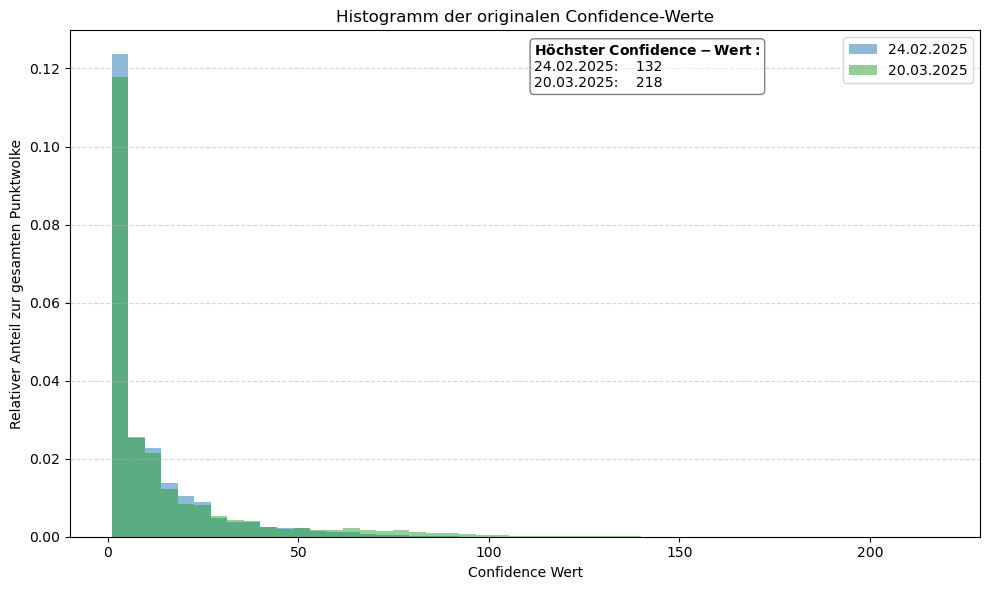

In [4]:
# Pfade zu den beiden Punktwolken (LAS-Dateien)
CraneCamZHAW20250224 = "D:\\BTh11_Asuwertung_PC\\fhnw_code\\BTh11_Trieblaengenwachstum\\09_CraneCam_ZHAW_Comparison\\90_BaseData\\PointCloud\\20250224_CraneCam_ZHAW_clipped.las"
CraneCamZHAW20250320 = "D:\\BTh11_Asuwertung_PC\\fhnw_code\\BTh11_Trieblaengenwachstum\\09_CraneCam_ZHAW_Comparison\\90_BaseData\\PointCloud\\20250320_CraneCam_ZHAW_clipped.las"

# Dateien prüfen
if not os.path.exists(CraneCamZHAW20250224):
    raise FileNotFoundError(f"Datei nicht gefunden: {CraneCamZHAW20250224}")
if not os.path.exists(CraneCamZHAW20250320):
    raise FileNotFoundError(f"Datei nicht gefunden: {CraneCamZHAW20250320}")

# Funktion, um die Confidence-Werte aus einer LAS-Datei zu extrahieren
def get_confidence_values(file_path):
    las = laspy.read(file_path)
    if "confidence" not in las.point_format.dimension_names:
        raise ValueError(f"Feld 'confidence' fehlt in Datei: {file_path}")
    return las['confidence']

# Confidence-Werte für beide Punktwolken extrahieren
CraneCamZHAW20250224_confidence = get_confidence_values(CraneCamZHAW20250224)
CraneCamZHAW20250320_confidence = get_confidence_values(CraneCamZHAW20250320)

# Bestimme die minimalen und maximalen Confidence-Werte für jede Punktwolke
min_conf1, max_conf1 = np.min(CraneCamZHAW20250224_confidence), np.max(CraneCamZHAW20250224_confidence)
min_conf2, max_conf2 = np.min(CraneCamZHAW20250320_confidence), np.max(CraneCamZHAW20250320_confidence)

# Ausgabe der Werte in der Konsole
print("24.02.2025 - Min:", min_conf1, "Max:", max_conf1)
print("20.03.2025 - Min:", min_conf2, "Max:", max_conf2)

# Optional: Bestimme den gemeinsamen Wertebereich für ein einheitliches Binning
min_conf = min(min_conf1, min_conf2)
max_conf = max(max_conf1, max_conf2)
bins = np.linspace(min_conf, max_conf, 51)  # 50 Bins

# Plot vorbereiten: Histogramm der originalen Confidence-Werte
fig, ax = plt.subplots(figsize=(10, 6))

ax.hist(CraneCamZHAW20250224_confidence, bins=bins, density=True, alpha=0.5, label="24.02.2025", color="#1f77b4")
ax.hist(CraneCamZHAW20250320_confidence, bins=bins, density=True, alpha=0.5, label="20.03.2025", color="#2ca02c")

ax.set_xlabel("Confidence Wert")
ax.set_ylabel("Relativer Anteil zur gesamten Punktwolke")
ax.set_title("Histogramm der originalen Confidence-Werte")
ax.legend(loc="upper right")
ax.grid(axis="y", linestyle="--", alpha=0.5)

# Textbox mit den min/max-Werten in die Grafik einfügen (oben links)
textstr = (
    r"$\mathbf{Höchster\ Confidence-Wert:}$" "\n"
    f"24.02.2025:    {max_conf1:.0f}\n"
    f"20.03.2025:    {max_conf2:.0f}"
)
props = dict(boxstyle="round", facecolor="white", alpha=0.5)
ax.text(0.51, 0.9752, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment="top", bbox=props)

plt.tight_layout()
plt.show()


24.02.2025 - Min: 1 Max: 132
20.03.2025 - Min: 1 Max: 218


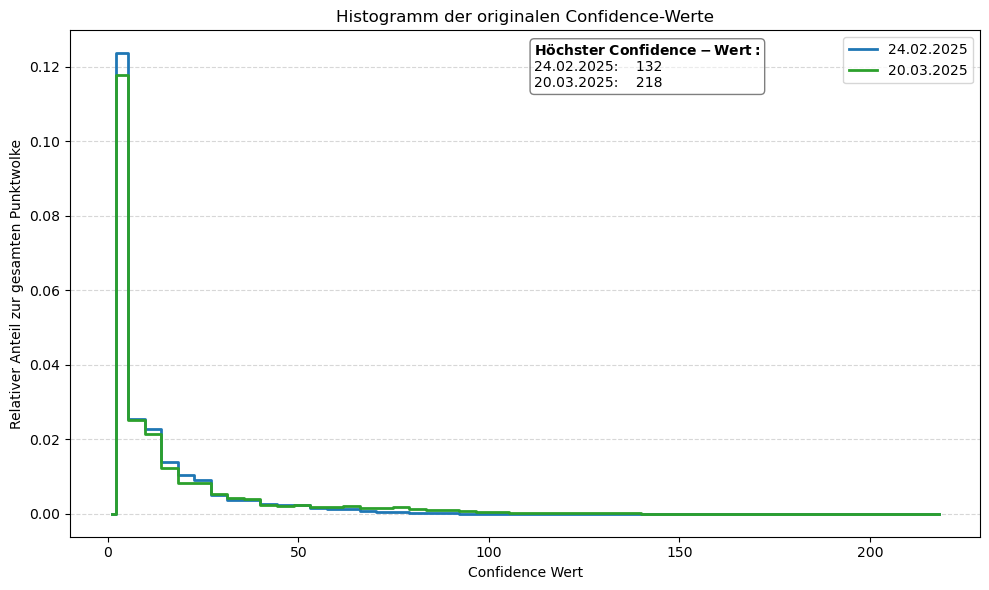

In [5]:
# Pfade zu den beiden Punktwolken (LAS-Dateien)
CraneCamZHAW20250224 = "D:\\BTh11_Asuwertung_PC\\fhnw_code\\BTh11_Trieblaengenwachstum\\09_CraneCam_ZHAW_Comparison\\90_BaseData\\PointCloud\\20250224_CraneCam_ZHAW_clipped.las"
CraneCamZHAW20250320 = "D:\\BTh11_Asuwertung_PC\\fhnw_code\\BTh11_Trieblaengenwachstum\\09_CraneCam_ZHAW_Comparison\\90_BaseData\\PointCloud\\20250320_CraneCam_ZHAW_clipped.las"

# Dateien prüfen
if not os.path.exists(CraneCamZHAW20250224):
    raise FileNotFoundError(f"Datei nicht gefunden: {CraneCamZHAW20250224}")
if not os.path.exists(CraneCamZHAW20250320):
    raise FileNotFoundError(f"Datei nicht gefunden: {CraneCamZHAW20250320}")

# Funktion, um die Confidence-Werte aus einer LAS-Datei zu extrahieren
def get_confidence_values(file_path):
    las = laspy.read(file_path)
    if "confidence" not in las.point_format.dimension_names:
        raise ValueError(f"Feld 'confidence' fehlt in Datei: {file_path}")
    return las['confidence']

# Confidence-Werte für beide Punktwolken extrahieren
CraneCamZHAW20250224_confidence = get_confidence_values(CraneCamZHAW20250224)
CraneCamZHAW20250320_confidence = get_confidence_values(CraneCamZHAW20250320)

# Bestimme die minimalen und maximalen Confidence-Werte für jede Punktwolke
min_conf1, max_conf1 = np.min(CraneCamZHAW20250224_confidence), np.max(CraneCamZHAW20250224_confidence)
min_conf2, max_conf2 = np.min(CraneCamZHAW20250320_confidence), np.max(CraneCamZHAW20250320_confidence)

# Ausgabe der Werte in der Konsole
print("24.02.2025 - Min:", min_conf1, "Max:", max_conf1)
print("20.03.2025 - Min:", min_conf2, "Max:", max_conf2)

# Optional: Bestimme den gemeinsamen Wertebereich für ein einheitliches Binning
min_conf = min(min_conf1, min_conf2)
max_conf = max(max_conf1, max_conf2)
bins = np.linspace(min_conf, max_conf, 51)  # 50 Bins

# Berechne Histogramme (mit density=True, um normierte Dichten zu erhalten)
hist_20250224, edges = np.histogram(CraneCamZHAW20250224_confidence, bins=bins, density=True)
hist_20250320, _ = np.histogram(CraneCamZHAW20250320_confidence, bins=bins, density=True)

# Berechne die Bin-Zentren
bin_centers = (edges[:-1] + edges[1:]) / 2

# Erweiterte Arrays erstellen, sodass die Linie bis zum Nullpunkt geht:
# Füge links den linken Rand (edges[0]) mit y=0 und rechts den rechten Rand (edges[-1]) mit y=0 hinzu.
x_extended = np.concatenate(([edges[0]], bin_centers, [edges[-1]]))
y_extended_20250224 = np.concatenate(([0], hist_20250224, [0]))
y_extended_20250320 = np.concatenate(([0], hist_20250320, [0]))

# Plot vorbereiten: Histogramm der originalen Confidence-Werte
fig, ax = plt.subplots(figsize=(10, 6))

ax.step(x_extended, y_extended_20250224, label="24.02.2025", color="#1f77b4", linewidth=2, where="mid")
ax.step(x_extended, y_extended_20250320, label="20.03.2025", color="#2ca02c", linewidth=2, where="mid")

ax.set_xlabel("Confidence Wert")
ax.set_ylabel("Relativer Anteil zur gesamten Punktwolke")
ax.set_title("Histogramm der originalen Confidence-Werte")
ax.legend(loc="upper right")
ax.grid(axis="y", linestyle="--", alpha=0.5)

# Textbox mit den min/max-Werten in die Grafik einfügen (oben links)
textstr = (
    r"$\mathbf{Höchster\ Confidence-Wert:}$" "\n"
    f"24.02.2025:    {max_conf1:.0f}\n"
    f"20.03.2025:    {max_conf2:.0f}"
)
props = dict(boxstyle="round", facecolor="white", alpha=0.5)
ax.text(0.51, 0.9752, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment="top", bbox=props)

plt.tight_layout()
plt.show()


### 2.3 Histogramm der Confidence-Werte der Punktwolken mit einer logarithmischen Skala - normiert (kontinuierlich)
In dieser Visualisierung werden alle Punkte der Punktwolken im Grundlagenverzeichnis "09_CraneCam_ZHAW_Comparison\90_BaseData\PointCloud" eingelesen und in Bezug auf das Attribut "confidence" in Kategorien eingeteilt. Pro Wert werden die normierten Anteile pro Aufnahmedatum in einer logarithsmischen Skala dargestellt.


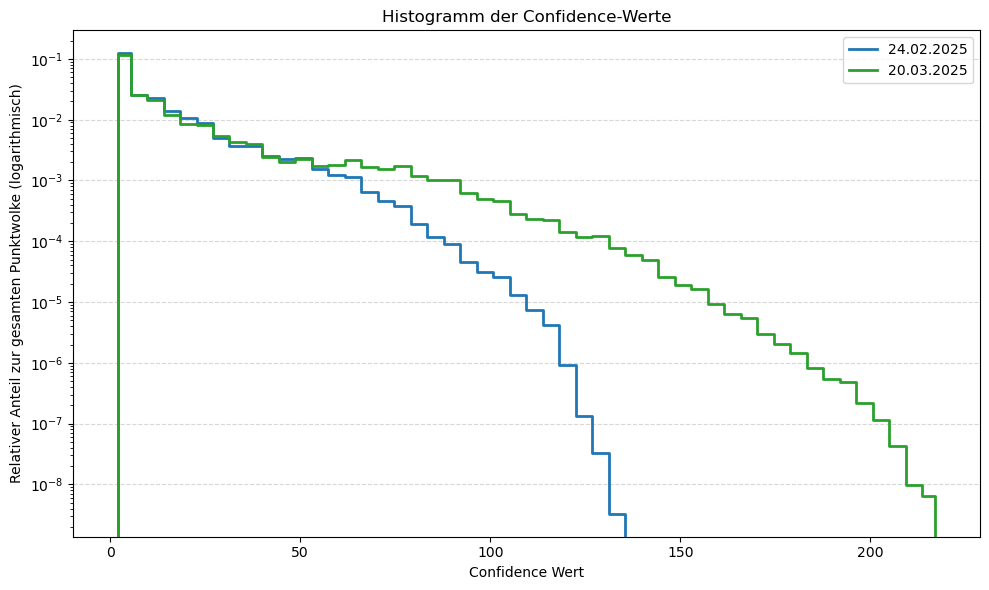

In [6]:
# Pfade zu den beiden Punktwolken (LAS-Dateien)
CraneCamZHAW20250224 = "D:\\BTh11_Asuwertung_PC\\fhnw_code\\BTh11_Trieblaengenwachstum\\09_CraneCam_ZHAW_Comparison\\90_BaseData\\PointCloud\\20250224_CraneCam_ZHAW_clipped.las"
CraneCamZHAW20250320 = "D:\\BTh11_Asuwertung_PC\\fhnw_code\\BTh11_Trieblaengenwachstum\\09_CraneCam_ZHAW_Comparison\\90_BaseData\\PointCloud\\20250320_CraneCam_ZHAW_clipped.las"

# Dateien prüfen
if not os.path.exists(CraneCamZHAW20250224):
    raise FileNotFoundError(f"Datei nicht gefunden: {CraneCamZHAW20250224}")
if not os.path.exists(CraneCamZHAW20250320):
    raise FileNotFoundError(f"Datei nicht gefunden: {CraneCamZHAW20250320}")

# Funktion, um die Confidence-Werte aus einer LAS-Datei zu extrahieren
def get_confidence_values(file_path):
    las = laspy.read(file_path)
    if "confidence" not in las.point_format.dimension_names:
        raise ValueError(f"Feld 'confidence' fehlt in Datei: {file_path}")
    return las['confidence']

# Confidence-Werte für beide Punktwolken extrahieren
CraneCamZHAW20250224_confidence = get_confidence_values(CraneCamZHAW20250224)
CraneCamZHAW20250320_confidence = get_confidence_values(CraneCamZHAW20250320)

# Optional: Bestimme den gemeinsamen Wertebereich für ein einheitliches Binning
min_conf = min(np.min(CraneCamZHAW20250224_confidence), np.min(CraneCamZHAW20250320_confidence))
max_conf = max(np.max(CraneCamZHAW20250224_confidence), np.max(CraneCamZHAW20250320_confidence))
bins = np.linspace(min_conf, max_conf, 51)  # 50 Bins

# Berechne Histogramme (mit density=True, um normierte Dichten zu erhalten)
hist_phantom, edges = np.histogram(CraneCamZHAW20250320_confidence, bins=bins, density=True)
hist_mini, _ = np.histogram(CraneCamZHAW20250224_confidence, bins=bins, density=True)

# Berechne die Bin-Zentren
bin_centers = (edges[:-1] + edges[1:]) / 2

# Erweiterte Arrays erstellen, sodass die Linie bis zum Nullpunkt geht:
# Füge links den linken Rand (edges[0]) mit y=0 und rechts den rechten Rand (edges[-1]) mit y=0 hinzu.
x_extended = np.concatenate(([edges[0]], bin_centers, [edges[-1]]))
y_extended_phantom = np.concatenate(([0], hist_phantom, [0]))
y_extended_mini = np.concatenate(([0], hist_mini, [0]))

# Plot vorbereiten: Linien-Histogramm
fig, ax = plt.subplots(figsize=(10, 6))

ax.step(x_extended, y_extended_mini, label="24.02.2025", color="#1f77b4", linewidth=2, where="mid")
ax.step(x_extended, y_extended_phantom, label="20.03.2025", color="#2ca02c", linewidth=2, where="mid")

ax.set_xlabel("Confidence Wert")
ax.set_ylabel("Relativer Anteil zur gesamten Punktwolke (logarithmisch)")
ax.set_title("Histogramm der Confidence-Werte")
ax.legend(loc="upper right")
ax.grid(axis="y", linestyle="--", alpha=0.5)

# Umstellung auf logarithmische y-Achse
ax.set_yscale("log")

plt.tight_layout()
plt.show()


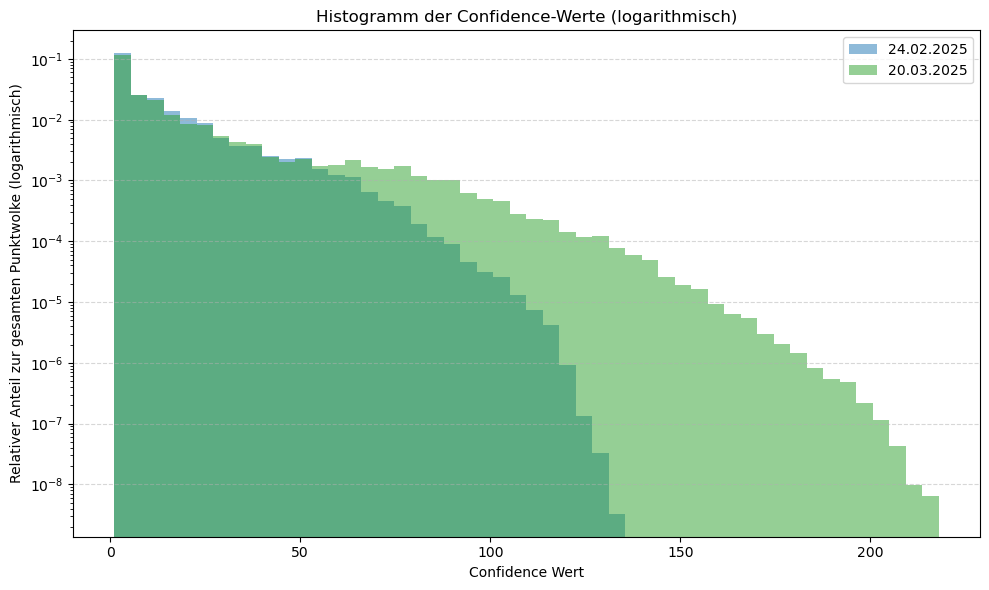

In [7]:
# Pfade zu den beiden Punktwolken (LAS-Dateien)
CraneCamZHAW20250224 = "D:\\BTh11_Asuwertung_PC\\fhnw_code\\BTh11_Trieblaengenwachstum\\09_CraneCam_ZHAW_Comparison\\90_BaseData\\PointCloud\\20250224_CraneCam_ZHAW_clipped.las"
CraneCamZHAW20250320 = "D:\\BTh11_Asuwertung_PC\\fhnw_code\\BTh11_Trieblaengenwachstum\\09_CraneCam_ZHAW_Comparison\\90_BaseData\\PointCloud\\20250320_CraneCam_ZHAW_clipped.las"

# Dateien prüfen
if not os.path.exists(CraneCamZHAW20250224):
    raise FileNotFoundError(f"Datei nicht gefunden: {CraneCamZHAW20250224}")
if not os.path.exists(CraneCamZHAW20250320):
    raise FileNotFoundError(f"Datei nicht gefunden: {CraneCamZHAW20250320}")

# Funktion, um die Confidence-Werte aus einer LAS-Datei zu extrahieren
def get_confidence_values(file_path):
    las = laspy.read(file_path)
    if "confidence" not in las.point_format.dimension_names:
        raise ValueError(f"Feld 'confidence' fehlt in Datei: {file_path}")
    return las['confidence']

# Confidence-Werte für beide Punktwolken extrahieren
CraneCamZHAW20250224_confidence = get_confidence_values(CraneCamZHAW20250224)
CraneCamZHAW20250320_confidence = get_confidence_values(CraneCamZHAW20250320)

# Optional: Bestimme den gemeinsamen Wertebereich für ein einheitliches Binning
min_conf = min(np.min(CraneCamZHAW20250224_confidence), np.min(CraneCamZHAW20250320_confidence))
max_conf = max(np.max(CraneCamZHAW20250224_confidence), np.max(CraneCamZHAW20250320_confidence))
bins = np.linspace(min_conf, max_conf, 51)  # 50 Bins

# Plot vorbereiten: Histogramm der originalen Confidence-Werte mit logarithmischer y-Achse
fig, ax = plt.subplots(figsize=(10, 6))

ax.hist(CraneCamZHAW20250224_confidence, bins=bins, density=True, alpha=0.5, label="24.02.2025", color="#1f77b4")
ax.hist(CraneCamZHAW20250320_confidence, bins=bins, density=True, alpha=0.5, label="20.03.2025", color="#2ca02c")

ax.set_xlabel("Confidence Wert")
ax.set_ylabel("Relativer Anteil zur gesamten Punktwolke (logarithmisch)")
ax.set_title("Histogramm der Confidence-Werte (logarithmisch)")
ax.legend(loc="upper right")
ax.grid(axis="y", linestyle="--", alpha=0.5)

# Umstellung auf logarithmische y-Achse
ax.set_yscale("log")

plt.tight_layout()
plt.show()


### 2.4 Histogramm der Confidence-Werte der Punktwolken mit einer logarithmischen Skala - Anzahl Punkte(kontinuierlich)
In dieser Visualisierung werden alle Punkte der Punktwolken im Grundlagenverzeichnis "09_CraneCam_ZHAW_Comparison\90_BaseData\PointCloud" eingelesen und in Bezug auf das Attribut "confidence" in Kategorien eingeteilt. Pro Wert werden die Anzahl Punkte pro Aufnahmedatum in einer logarithsmischen Skala dargestellt.


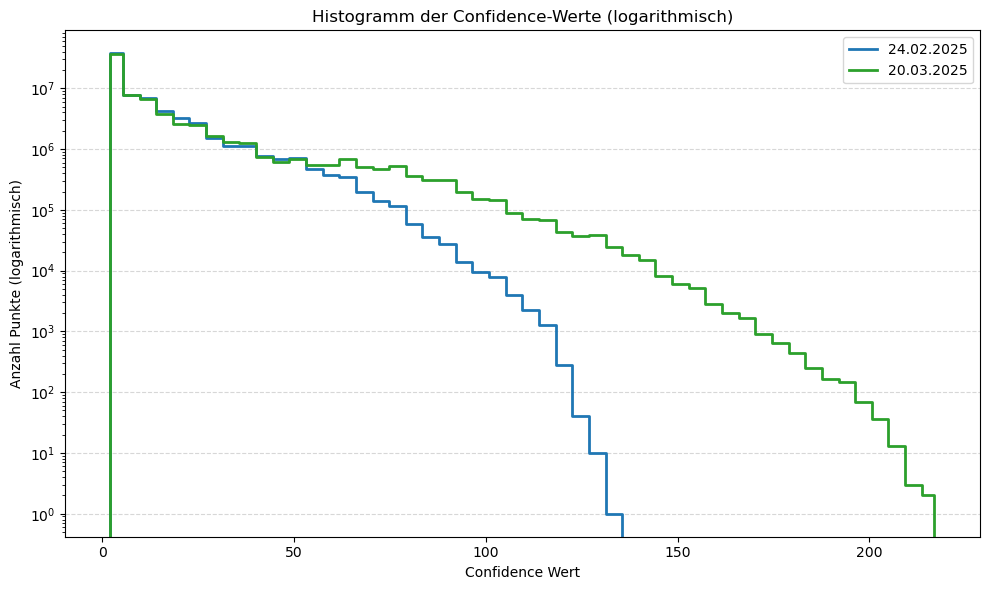

In [9]:
# Pfade zu den beiden Punktwolken (LAS-Dateien)
CraneCamZHAW20250224 = "D:\\BTh11_Asuwertung_PC\\fhnw_code\\BTh11_Trieblaengenwachstum\\09_CraneCam_ZHAW_Comparison\\90_BaseData\\PointCloud\\20250224_CraneCam_ZHAW_clipped.las"
CraneCamZHAW20250320 = "D:\\BTh11_Asuwertung_PC\\fhnw_code\\BTh11_Trieblaengenwachstum\\09_CraneCam_ZHAW_Comparison\\90_BaseData\\PointCloud\\20250320_CraneCam_ZHAW_clipped.las"

# Dateien prüfen
if not os.path.exists(CraneCamZHAW20250224):
    raise FileNotFoundError(f"Datei nicht gefunden: {CraneCamZHAW20250224}")
if not os.path.exists(CraneCamZHAW20250320):
    raise FileNotFoundError(f"Datei nicht gefunden: {CraneCamZHAW20250320}")

# Funktion, um die Confidence-Werte aus einer LAS-Datei zu extrahieren
def get_confidence_values(file_path):
    las = laspy.read(file_path)
    if "confidence" not in las.point_format.dimension_names:
        raise ValueError(f"Feld 'confidence' fehlt in Datei: {file_path}")
    return las['confidence']

# Confidence-Werte für beide Punktwolken extrahieren
CraneCamZHAW20250224_confidence = get_confidence_values(CraneCamZHAW20250224)
CraneCamZHAW20250320_confidence = get_confidence_values(CraneCamZHAW20250320)

# Optional: Bestimme den gemeinsamen Wertebereich für ein einheitliches Binning
min_conf = min(np.min(CraneCamZHAW20250224_confidence), np.min(CraneCamZHAW20250320_confidence))
max_conf = max(np.max(CraneCamZHAW20250224_confidence), np.max(CraneCamZHAW20250320_confidence))
bins = np.linspace(min_conf, max_conf, 51)  # 50 Bins

# Berechne Histogramme (mit density=True, um normierte Dichten zu erhalten)
hist_20250320, edges = np.histogram(CraneCamZHAW20250320_confidence, bins=bins, density=False)
hist_20250224, _ = np.histogram(CraneCamZHAW20250224_confidence, bins=bins, density=False)

# Berechne die Bin-Zentren
bin_centers = (edges[:-1] + edges[1:]) / 2

# Erweiterte Arrays erstellen, sodass die Linie bis zum Nullpunkt geht:
# Füge links den linken Rand (edges[0]) mit y=0 und rechts den rechten Rand (edges[-1]) mit y=0 hinzu.
x_extended = np.concatenate(([edges[0]], bin_centers, [edges[-1]]))
y_extended_20250320 = np.concatenate(([0], hist_20250320, [0]))
y_extended_20250224 = np.concatenate(([0], hist_20250224, [0]))

# Plot vorbereiten: Histogramm der originalen Confidence-Werte mit logarithmischer y-Achse
fig, ax = plt.subplots(figsize=(10, 6))

ax.step(x_extended, y_extended_20250224, label="24.02.2025", color="#1f77b4", linewidth=2, where="mid")
ax.step(x_extended, y_extended_20250320, label="20.03.2025", color="#2ca02c", linewidth=2, where="mid")

ax.set_xlabel("Confidence Wert")
ax.set_ylabel("Anzahl Punkte (logarithmisch)")
ax.set_title("Histogramm der Confidence-Werte (logarithmisch)")
ax.legend(loc="upper right")
ax.grid(axis="y", linestyle="--", alpha=0.5)

# Umstellung auf logarithmische y-Achse
ax.set_yscale("log")

plt.tight_layout()
plt.show()


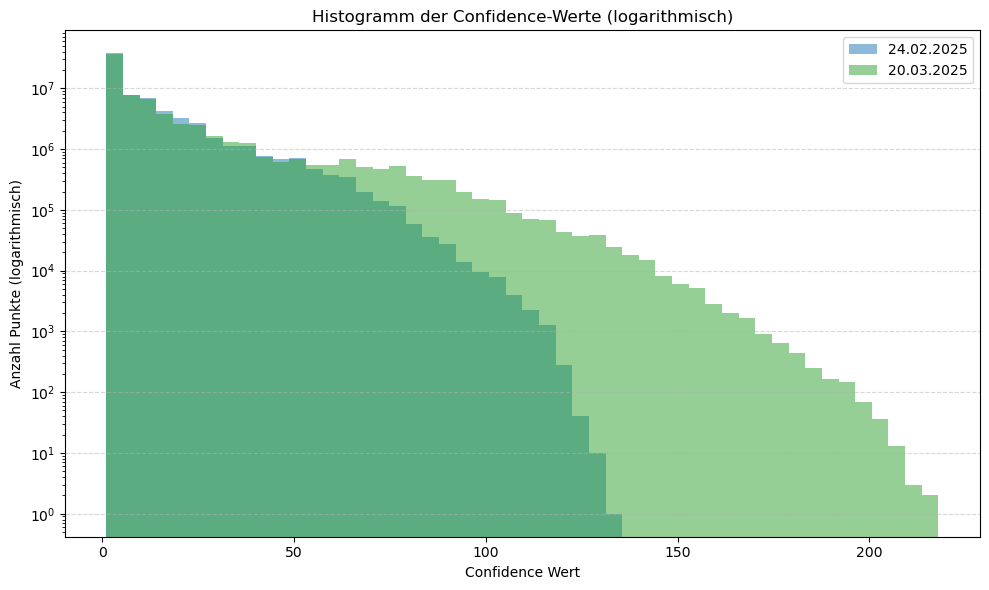

In [20]:
# Pfade zu den beiden Punktwolken (LAS-Dateien)
CraneCamZHAW20250224 = "D:\\BTh11_Asuwertung_PC\\fhnw_code\\BTh11_Trieblaengenwachstum\\09_CraneCam_ZHAW_Comparison\\90_BaseData\\PointCloud\\20250224_CraneCam_ZHAW_clipped.las"
CraneCamZHAW20250320 = "D:\\BTh11_Asuwertung_PC\\fhnw_code\\BTh11_Trieblaengenwachstum\\09_CraneCam_ZHAW_Comparison\\90_BaseData\\PointCloud\\20250320_CraneCam_ZHAW_clipped.las"

# Dateien prüfen
if not os.path.exists(CraneCamZHAW20250224):
    raise FileNotFoundError(f"Datei nicht gefunden: {CraneCamZHAW20250224}")
if not os.path.exists(CraneCamZHAW20250320):
    raise FileNotFoundError(f"Datei nicht gefunden: {CraneCamZHAW20250320}")

# Funktion, um die Confidence-Werte aus einer LAS-Datei zu extrahieren
def get_confidence_values(file_path):
    las = laspy.read(file_path)
    if "confidence" not in las.point_format.dimension_names:
        raise ValueError(f"Feld 'confidence' fehlt in Datei: {file_path}")
    return las['confidence']

# Confidence-Werte für beide Punktwolken extrahieren
CraneCamZHAW20250224_confidence = get_confidence_values(CraneCamZHAW20250224)
CraneCamZHAW20250320_confidence = get_confidence_values(CraneCamZHAW20250320)

# Optional: Bestimme den gemeinsamen Wertebereich für ein einheitliches Binning
min_conf = min(np.min(CraneCamZHAW20250224_confidence), np.min(CraneCamZHAW20250320_confidence))
max_conf = max(np.max(CraneCamZHAW20250224_confidence), np.max(CraneCamZHAW20250320_confidence))
bins = np.linspace(min_conf, max_conf, 51)  # 50 Bins

# Plot vorbereiten: Histogramm der originalen Confidence-Werte mit logarithmischer y-Achse
fig, ax = plt.subplots(figsize=(10, 6))

ax.hist(CraneCamZHAW20250224_confidence, bins=bins, alpha=0.5, label="24.02.2025", color="#1f77b4")
ax.hist(CraneCamZHAW20250320_confidence, bins=bins, alpha=0.5, label="20.03.2025", color="#2ca02c")

ax.set_xlabel("Confidence Wert")
ax.set_ylabel("Anzahl Punkte (logarithmisch)")
ax.set_title("Histogramm der Confidence-Werte (logarithmisch)")
ax.legend(loc="upper right")
ax.grid(axis="y", linestyle="--", alpha=0.5)

# Umstellung auf logarithmische y-Achse
ax.set_yscale("log")

plt.tight_layout()
plt.show()


In [21]:
# Überprüfen, ob das Verzeichnis existiert
if not os.path.exists(pc_dir):
    raise FileNotFoundError(f"Verzeichnis nicht gefunden: {pc_dir}")

# Liste aller LAS-Dateien im Ordner
las_files = [f for f in os.listdir(pc_dir) if f.lower().endswith(".las")]

# Für jede Datei wird die Anzahl der Punkte ermittelt und ausgegeben.
for filename in las_files:
    file_path = os.path.join(pc_dir, filename)
    las = laspy.read(file_path)
    # Anzahl der Punkte (als Länge des Arrays der Punktdaten)
    num_points = len(las.points)
    print(f"{filename}: {num_points} Punkte")

20250224_CraneCam_ZHAW_clipped.las: 70053440 Punkte
20250320_CraneCam_ZHAW_clipped.las: 71075193 Punkte
